In [124]:
#MSDS 464 - This is the Neural network part of the Final project, see how NN vs DRL can be used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io


import tensorflow as tf
from time import time 

from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical


In [2]:
tf.__version__

'2.1.0'

In [3]:
# set up base class for callbacks to monitor training
# and for early stopping during training
#binary classification uses sigmoid and sparse_categorical_crossentropy/binary_crossentropy  
tf.keras.callbacks.Callback()

In [4]:
earlystop_callback = \
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',\
    min_delta=0.01, patience=5, verbose=0, mode='auto',\
    baseline=None, restore_best_weights=False)

In [5]:
def plot_auc(nnName, y_test, y_pred):
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best') 
    plt.savefig('Result_Diagrams/'+ nnName + '-AUC_ZoomAUC.pdf', 
        papertype = 'letter', orientation ='landscape')
    plt.show()
    plt.close()

In [6]:
# The training process may be evaluated by comparing training and
# dev (validation) set performance. We use "dev" to indicate
# that these data are used in evaluating various hyperparameter
# settings. We do not test alternative hyperparameters here,
# but in other programs there will be much hyperparameter testing.
def plot_history(nnName, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_number = range(1, len(acc) + 1)
    plt.style.use('ggplot') # Grammar of Graphics plots
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_number, acc, 'b', label='Training')
    plt.plot(epoch_number, val_acc, 'r', label='Dev')
    plt.title('Training and Dev Set Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epoch_number, loss, 'b', label='Training')
    plt.plot(epoch_number, val_loss, 'r', label='Dev')
    plt.title('Training and Dev Set Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('Result_Diagrams/'+ nnName + 'fig-training-process.pdf', 
        papertype = 'letter', orientation ='landscape')
    plt.show()
    plt.close()

In [7]:
def evaluate_fitted_model_train_test(modelname, model, X_train, y_train, X_test, y_test, X_dev, y_dev):
      # evaluate fitted model on the full training set
      train_loss, train_acc = model.evaluate(X_train,y_train,verbose = 3)
      print('\n' + modelname + ' Full training set accuracy:', \
                '{:6.4f}'.format(np.round(train_acc, decimals = 4)), '\n')
        
      # evaluate fitted model on the full training set
      dev_loss, dev_acc = model.evaluate(X_dev,y_dev,verbose = 3)
      print( modelname + ' Development set accuracy:', \
                '{:6.4f}'.format(np.round(dev_acc, decimals = 4)), '\n')
        
      # evaluate the fitted model on the hold-out test set
      test_loss, test_acc = model.evaluate(X_test,  y_test, verbose = 3)
      print(modelname + ' Hold-out test set accuracy:', \
                '{:6.4f}'.format(np.round(test_acc, decimals = 4)))
    
      return train_acc, dev_acc, test_acc


In [8]:
def evaluate_model(modelname, model, max_epochs, X_train, y_train, X_dev, y_dev, X_test, y_test, earlystop_callback):
        begin_time = time()
        history = model.fit(X_train,
                            y_train, 
                            epochs = max_epochs, 
                            shuffle = False,
                            validation_data = (X_dev,y_dev), verbose = 2, 
                            callbacks = [earlystop_callback])
        execution_time = time() - begin_time
        print('\n' + modelname + ' Time of execution for training (seconds):', \
                 '{:10.3f}'.format(np.round(execution_time, decimals = 3)))

        #evaluate a fitted model
        train_acc, dev_acc, test_acc =\
           evaluate_fitted_model_train_test(modelname, model, X_train, y_train, X_test, y_test, X_dev, y_dev)
        
        y_pred_keras = model.predict(X_test)
        #print(y_pred_keras)
        
        # calculate roc auc
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
        roc_auc = auc(fpr_keras, tpr_keras)
        print('\n' + modelname + ' ROC AUC %.3f' % roc_auc)

        # show training process in external visualizations
        plot_history(modelname, history) 
        
        plot_auc(modelname, y_test, y_pred_keras)
        

        return [modelname,execution_time, train_acc, dev_acc, test_acc,roc_auc]
     

<h5> Conv1D Model </h5>

In [9]:
def Conv1D_model(voc_size,embedding_vector_feature, max_length, numberClasses, dropout = 0):
    # define the structure of the model
    model = Sequential(name = 'conv1D_nn_model')
    model.add(Embedding(voc_size,embedding_vector_feature, input_length=max_length))
    model.add(Conv1D(filters = 32, kernel_size = 8, activation = 'relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(80, activation = 'relu'))
    model.add(Dense(40, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(Dense(numberClasses, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

<h5>LSTM Model </h5>

In [10]:
def LSTM_model(voc_size,embedding_vector_feature, max_length, numberClasses, dropout = 0):
    # define the structure of the model
    model = Sequential()
    model.add(Embedding(voc_size,embedding_vector_feature, input_length=max_length))
    model.add(LSTM(100))
    model.add(Dense(80, activation = 'relu'))
    model.add(Dense(40, activation = 'relu'))
    model.add(Dense(20, activation = 'relu'))
    model.add(Dense(10, activation = 'relu'))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(Dense(numberClasses, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model


<h5>GRU neural Network</h5>

In [11]:
def GRU_model(voc_size,embedding_vector_feature, max_length, numberClasses, dropout = 0):
    # GRU neural Network
    gru_model = Sequential()
    gru_model.add(Embedding(voc_size,embedding_vector_feature, input_length=max_length))
    gru_model.add(GRU(100))
    gru_model.add(Dense(80, activation = 'relu', name = '3rd_layer'))
    gru_model.add(Dense(40, activation = 'relu', name = '4th_layer'))
    gru_model.add(Dense(20, activation = 'relu', name = '5th_layer'))
    gru_model.add(Dense(10, activation = 'relu', name = '6th_layer'))
    if dropout > 0:
        gru_model.add(tf.keras.layers.Dropout(dropout))
    gru_model.add(Dense(numberClasses, activation='sigmoid', name = 'output_layer'))
    # compiling the model
    gru_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    gru_model.summary()
    return gru_model

<h5>Bidirectional LSTM</h5>

In [12]:
def Bi_RNN_model(voc_size,embedding_vector_feature, max_length, numberClasses, dropout = 0):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(voc_size,embedding_vector_feature, input_length=max_length))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)))
    model.add(tf.keras.layers.Dense(80, activation='relu'))
    model.add(tf.keras.layers.Dense(40, activation='relu'))
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(numberClasses, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

<h2>Data Prep</h2>

In [16]:
train=pd.read_csv('Data/train.csv')

In [17]:
# determine the unique number of label classes 0/1
df_train= train.dropna()
nclasses = len(set(df_train['label'])) -1
print(nclasses)

1


In [18]:
#Is slightly imabalabed 4:6 ratio, no
y=df_train['label']
print(y.value_counts())

0    10361
1     7924
Name: label, dtype: int64


In [19]:
# natural language processing model hyperparameters
vocab_size    = 10000          # number of unique words to use in tokenization
embedding_vector_feature = 40  # dimension of neural network embedding for a word
max_length    = 30             # number of words to be retained in each document
max_epochs    = 10   
result       = list()

<b>Word Embedding and One Hot Encoding setup</b>

In [20]:
df_train= train.dropna()
y= df_train['label']
y_final=np.array(y)
traindocs = df_train['title']
y_final

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [21]:
# set up tokenizer based on the training documents only
# default filter includes basic punctuation, tabs, and newlines
# filters = !"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n
# we add all numbers to this filter 
# default is to convert to lowercase letters
# default is to split on spaces
# oov_token is used for out-of-vocabulary words
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV',
    filters = '0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n')
tokenizer.fit_on_texts(traindocs)
word_index = tokenizer.word_index 
# word_index is a dictionary of words and their uniquely assigned integers
print('Training vocabulary size with one out-of-vocabulary item: ',
    len(word_index)) 
print('\nFirst five key-value pairs in word_index:')
[print(item) for key, item in enumerate(word_index.items()) if key < 5] 

# execute helper function to create a reverse dictionary
# so if we are given an index value we can retrieve the associated word
reverse_word_index = \
    dict([(value, key) for (key, value) in word_index.items()])

Training vocabulary size with one out-of-vocabulary item:  25324

First five key-value pairs in word_index:
('OOV', 1)
('the', 2)
('new', 3)
('york', 4)
('times', 5)


In [22]:
#https://www.onceupondata.com/2019/01/21/keras-text-part1/
def word_embeddding_encode_docs(tokenizer, max_length, docs):
    encoded = tokenizer.texts_to_sequences(docs) # words to integers
    padded = pad_sequences(encoded, 
                           maxlen = max_length, 
                           padding = 'post', 
                           truncating = 'post', 
                           value = 0)
    return padded  


In [23]:
#https://github.com/pemagrg1/one-hot-encoding/blob/master/one%20hot%20encoding%20using%20sklearn
def one_hot_encoding_docs(tokenizer, doc, max_length):
    # One hot encodode using keras
    encoded_docs = tokenizer.texts_to_matrix(doc, mode='count')
    padded = pad_sequences(encoded_docs, 
                           maxlen = max_length, 
                           padding = 'post', 
                           truncating = 'post',
                           value = 0)
    return padded


In [24]:
def train_dev_test_split(train_sequence):
    # implementing a tripartite splitting into train, dev, and test
    train_ratio = 0.75
    dev_ratio = 0.15
    test_ratio = 0.10
    
    # train is now 75% of the entire data set
    X_train, X_test, y_train, y_test = train_test_split(train_sequence, 
                                                    y_final, test_size=(1 - train_ratio), 
                                                    random_state=42)
    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, 
                                                test_size=test_ratio/(test_ratio + dev_ratio),\
                                               random_state=42 )
    #print(X_train.shape, X_dev.shape, X_test.shape)
    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [25]:
conv1d_model = Conv1D_model(vocab_size,embedding_vector_feature,max_length, nclasses)

Model: "conv1D_nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 40)            400000    
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 32)            10272     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 80)                2640      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)            

In [26]:
lstm_model = LSTM_model(vocab_size,embedding_vector_feature,max_length, nclasses)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 40)            400000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense_5 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_6 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1

In [27]:
gru_model = GRU_model(vocab_size,embedding_vector_feature,max_length, nclasses)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 40)            400000    
_________________________________________________________________
gru (GRU)                    (None, 100)               42600     
_________________________________________________________________
3rd_layer (Dense)            (None, 80)                8080      
_________________________________________________________________
4th_layer (Dense)            (None, 40)                3240      
_________________________________________________________________
5th_layer (Dense)            (None, 20)                820       
_________________________________________________________________
6th_layer (Dense)            (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 1)                

<b>Bidirectional RNNs</b>

In [28]:
bi_lstm_model = Bi_RNN_model(vocab_size,embedding_vector_feature,max_length, nclasses)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 40)            400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dense_10 (Dense)             (None, 80)                16080     
_________________________________________________________________
dense_11 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_12 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

<h6>NN models with 0.25 Dropout</h6>

In [29]:
dropout=0.25

In [30]:
conv1d_model025 = Conv1D_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)
lstm_model025 = LSTM_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)
gru_model025 = GRU_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)
bi_lstm_model025 = Bi_RNN_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)

Model: "conv1D_nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 40)            400000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 32)            10272     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 80)                2640      
_________________________________________________________________
dense_16 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_17 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_18 (Dense)             (None, 10)            

<h6>NN models with 0.5 Dropout</h6>

In [31]:
dropout = 0.5

In [32]:
conv1d_model05 = Conv1D_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)
lstm_model05 = LSTM_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)
gru_model05 = GRU_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)
bi_lstm_model05 = Bi_RNN_model(vocab_size,embedding_vector_feature,max_length, nclasses, dropout)

Model: "conv1D_nn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 40)            400000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 32)            10272     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 80)                2640      
_________________________________________________________________
dense_31 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_32 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_33 (Dense)             (None, 10)            

<h4>Generally speaking, an experiment comparing the performance of alternative neural network language 
   models or techniques would be a good research topic for this assignment. </h4>

<ul>
    <li>1. Consider using a factorial design with alternative methods (dense, 1D CNN, LSTM, versus GRU) 
        as one of the factors. </li>
    <li>2. A comparison of one-hot encoding versus word embeddings for word/term vectorization 
        could be another factor.</li> 
    <li>Comparisons across alternative settings for dropout regularization (none, 5 percent,50 percent)
        may also be useful.</li> 
</ul> 

<h2>One hot encoding</h2>

In [33]:
train_sequence_one_hotEncoding = one_hot_encoding_docs(tokenizer, traindocs, max_length)
train_sequence_one_hotEncoding

#One hot encoding
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_split(train_sequence_one_hotEncoding)

<b>Conv1D Model</b>

Train on 13713 samples, validate on 2743 samples
Epoch 1/10
13713/13713 - 3s - loss: 0.4518 - accuracy: 0.7704 - val_loss: 0.4369 - val_accuracy: 0.7645
Epoch 2/10
13713/13713 - 2s - loss: 0.4111 - accuracy: 0.7814 - val_loss: 0.4233 - val_accuracy: 0.7725
Epoch 3/10
13713/13713 - 2s - loss: 0.4051 - accuracy: 0.7847 - val_loss: 0.4200 - val_accuracy: 0.7751
Epoch 4/10
13713/13713 - 2s - loss: 0.4001 - accuracy: 0.7853 - val_loss: 0.4151 - val_accuracy: 0.7751
Epoch 5/10
13713/13713 - 2s - loss: 0.3957 - accuracy: 0.7884 - val_loss: 0.4091 - val_accuracy: 0.7794
Epoch 6/10
13713/13713 - 2s - loss: 0.3926 - accuracy: 0.7919 - val_loss: 0.4036 - val_accuracy: 0.7845
Epoch 7/10
13713/13713 - 2s - loss: 0.3904 - accuracy: 0.7930 - val_loss: 0.4021 - val_accuracy: 0.7871
Epoch 8/10
13713/13713 - 2s - loss: 0.3882 - accuracy: 0.7946 - val_loss: 0.4009 - val_accuracy: 0.7918
Epoch 9/10
13713/13713 - 2s - loss: 0.3868 - accuracy: 0.7960 - val_loss: 0.3968 - val_accuracy: 0.7878
Epoch 10/10
137

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


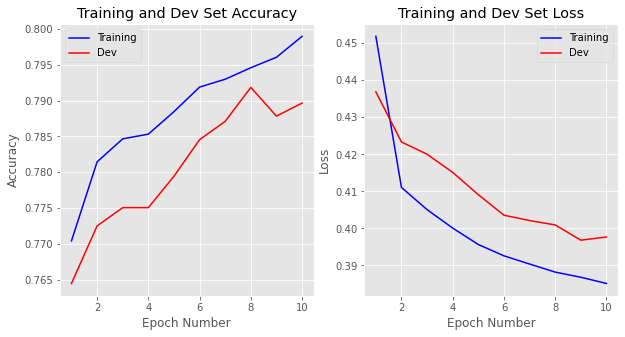

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


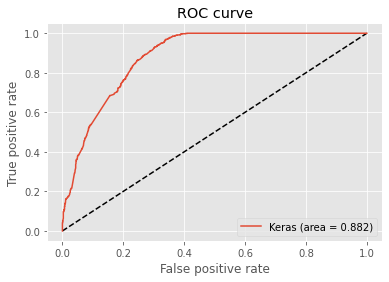

In [34]:
res = evaluate_model('Conv1D One Hot Encoding', conv1d_model, max_epochs, X_train, y_train, X_dev, y_dev, 
                                                               X_test, y_test, earlystop_callback)
result.append(res)

<b>Conv1D Model 0.25</b>

Train on 13713 samples, validate on 2743 samples
Epoch 1/10
13713/13713 - 3s - loss: 0.4692 - accuracy: 0.7669 - val_loss: 0.4252 - val_accuracy: 0.7656
Epoch 2/10
13713/13713 - 2s - loss: 0.4381 - accuracy: 0.7766 - val_loss: 0.4184 - val_accuracy: 0.7656
Epoch 3/10
13713/13713 - 2s - loss: 0.4301 - accuracy: 0.7793 - val_loss: 0.4156 - val_accuracy: 0.7754
Epoch 4/10
13713/13713 - 2s - loss: 0.4240 - accuracy: 0.7774 - val_loss: 0.4038 - val_accuracy: 0.7729
Epoch 5/10
13713/13713 - 2s - loss: 0.4202 - accuracy: 0.7793 - val_loss: 0.4004 - val_accuracy: 0.7853
Epoch 6/10
13713/13713 - 2s - loss: 0.4168 - accuracy: 0.7800 - val_loss: 0.3977 - val_accuracy: 0.7827
Epoch 7/10
13713/13713 - 2s - loss: 0.4141 - accuracy: 0.7855 - val_loss: 0.3958 - val_accuracy: 0.7813
Epoch 8/10
13713/13713 - 2s - loss: 0.4136 - accuracy: 0.7836 - val_loss: 0.3942 - val_accuracy: 0.7988
Epoch 9/10
13713/13713 - 2s - loss: 0.4121 - accuracy: 0.7872 - val_loss: 0.3943 - val_accuracy: 0.7951
Epoch 10/10
137

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


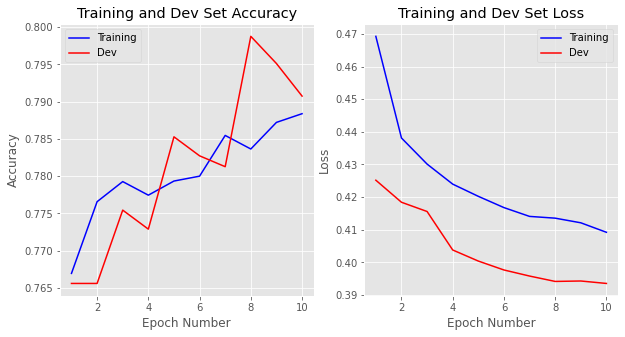

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


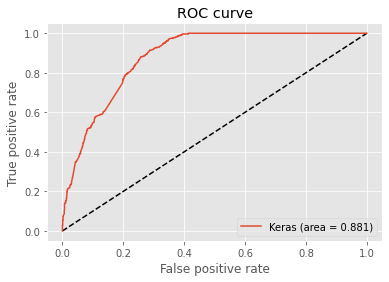

In [35]:
res = evaluate_model('Conv1D Dropout 0.25 one hot encoding', conv1d_model025, 
                                       max_epochs, 
                                       X_train, y_train, 
                                       X_dev, y_dev, 
                                       X_test, y_test, 
                                       earlystop_callback)
result.append(res)

<b>Conv1D Model 0.5</b>

Train on 13713 samples, validate on 2743 samples
Epoch 1/10
13713/13713 - 3s - loss: 0.4829 - accuracy: 0.7487 - val_loss: 0.4254 - val_accuracy: 0.7641
Epoch 2/10
13713/13713 - 2s - loss: 0.4467 - accuracy: 0.7584 - val_loss: 0.4227 - val_accuracy: 0.7765
Epoch 3/10
13713/13713 - 2s - loss: 0.4390 - accuracy: 0.7596 - val_loss: 0.4067 - val_accuracy: 0.7776
Epoch 4/10
13713/13713 - 2s - loss: 0.4367 - accuracy: 0.7591 - val_loss: 0.4031 - val_accuracy: 0.7783
Epoch 5/10
13713/13713 - 3s - loss: 0.4340 - accuracy: 0.7594 - val_loss: 0.4105 - val_accuracy: 0.7714
Epoch 6/10
13713/13713 - 3s - loss: 0.4322 - accuracy: 0.7593 - val_loss: 0.4041 - val_accuracy: 0.7740
Epoch 7/10
13713/13713 - 3s - loss: 0.4296 - accuracy: 0.7620 - val_loss: 0.3991 - val_accuracy: 0.7834

Conv1D Dropout 0.25 one hot encoding Time of execution for training (seconds):     18.051

Conv1D Dropout 0.25 one hot encoding Full training set accuracy: 0.7859 

Conv1D Dropout 0.25 one hot encoding Development set accu

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


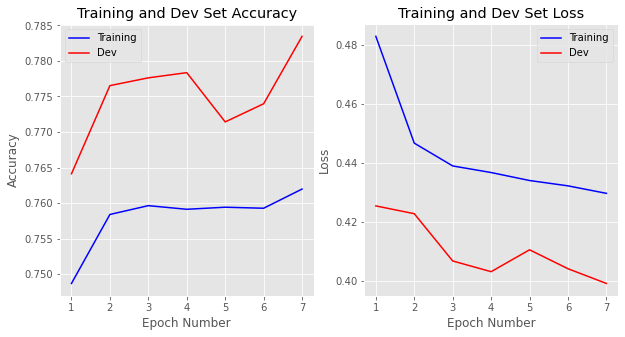

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


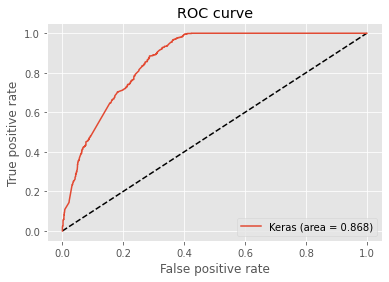

In [36]:
res = evaluate_model('Conv1D Dropout 0.25 one hot encoding', conv1d_model05, 
                                       max_epochs, 
                                       X_train, y_train, 
                                       X_dev, y_dev, 
                                       X_test, y_test, 
                                       earlystop_callback)
result.append(res)

<b>LSTM Model</b>

Train on 13713 samples, validate on 2743 samples
Epoch 1/10
13713/13713 - 10s - loss: 0.4674 - accuracy: 0.7513 - val_loss: 0.4456 - val_accuracy: 0.7681
Epoch 2/10
13713/13713 - 9s - loss: 0.4043 - accuracy: 0.7966 - val_loss: 0.4123 - val_accuracy: 0.7973
Epoch 3/10
13713/13713 - 7s - loss: 0.3866 - accuracy: 0.8080 - val_loss: 0.3959 - val_accuracy: 0.8112
Epoch 4/10
13713/13713 - 8s - loss: 0.3774 - accuracy: 0.8217 - val_loss: 0.4325 - val_accuracy: 0.7623
Epoch 5/10
13713/13713 - 8s - loss: 0.3711 - accuracy: 0.8263 - val_loss: 0.3612 - val_accuracy: 0.8410
Epoch 6/10
13713/13713 - 8s - loss: 0.3625 - accuracy: 0.8374 - val_loss: 0.3760 - val_accuracy: 0.8316
Epoch 7/10
13713/13713 - 7s - loss: 0.3434 - accuracy: 0.8547 - val_loss: 0.3083 - val_accuracy: 0.8826
Epoch 8/10
13713/13713 - 8s - loss: 0.3415 - accuracy: 0.8601 - val_loss: 0.3358 - val_accuracy: 0.8604
Epoch 9/10
13713/13713 - 7s - loss: 0.3065 - accuracy: 0.8749 - val_loss: 0.2974 - val_accuracy: 0.8790
Epoch 10/10
13

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


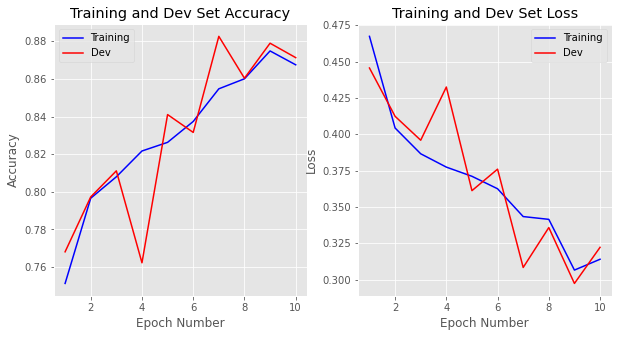

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


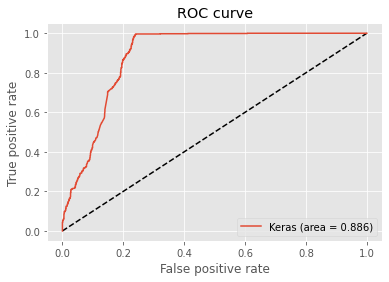

In [37]:
res =evaluate_model('LSTM One Hot Encoding', lstm_model, 
                                               max_epochs, 
                                               X_train, y_train, 
                                               X_dev, y_dev, 
                                               X_test, y_test, 
                                               earlystop_callback)
result.append(res)

<b>LSTM Model Dropout 0.25</b>

In [ ]:
res =evaluate_model('LSTM 0.25 Dropout One Hot Encoding', lstm_model025, 
                                               max_epochs, 
                                               X_train, y_train, 
                                               X_dev, y_dev, 
                                               X_test, y_test, 
                                               earlystop_callback)
result.append(res)

Train on 13713 samples, validate on 2743 samples
Epoch 1/10
13713/13713 - 9s - loss: 0.5086 - accuracy: 0.7203 - val_loss: 0.4584 - val_accuracy: 0.7568
Epoch 2/10
13713/13713 - 8s - loss: 0.4354 - accuracy: 0.7813 - val_loss: 0.4241 - val_accuracy: 0.7769
Epoch 3/10
13713/13713 - 7s - loss: 0.4070 - accuracy: 0.8050 - val_loss: 0.3944 - val_accuracy: 0.8002
Epoch 4/10
13713/13713 - 7s - loss: 0.3954 - accuracy: 0.8031 - val_loss: 0.3939 - val_accuracy: 0.7918
Epoch 5/10


<b>LSTM Model Dropout 0.5</b>

In [ ]:
res =evaluate_model('LSTM 0.5 Dropout One Hot Encoding', lstm_model05, 
                                               max_epochs, 
                                               X_train, y_train, 
                                               X_dev, y_dev, 
                                               X_test, y_test, 
                                               earlystop_callback)
result.append(res)

<b>GRU Model</b>

In [ ]:
res = evaluate_model('GRU.NN One Hot Encoding', gru_model, max_epochs, X_train, y_train,
                           X_dev, y_dev, X_test, y_test, earlystop_callback)
result.append(res)

<b>GRU Model 0.25</b>

In [ ]:
res = evaluate_model('GRU.NN 0.25 Dropout One Hot Encoding', gru_model025, max_epochs, X_train, y_train,
                           X_dev, y_dev, X_test, y_test, earlystop_callback)
result.append(res)

<b>GRU Model 0.5</b>

In [ ]:
res = evaluate_model('GRU.NN 0.5 Dropout One Hot Encoding', gru_model05, max_epochs, X_train, y_train,
                           X_dev, y_dev, X_test, y_test, earlystop_callback)
result.append(res)

<b>Bidirectional LSTMs</b>

In [ ]:
res = evaluate_model('Bidirection LSTM One Hot Encoding', bi_lstm_model, max_epochs, 
                                    X_train, y_train, X_dev, y_dev,
                                    X_test, y_test, earlystop_callback)
result.append(res)

<b>Bidirectional LSTMs 0.25</b>

In [ ]:
res = evaluate_model('Bidirection LSTM 0.25 Dropout One Hot Encoding', bi_lstm_model025, max_epochs, 
                                    X_train, y_train, X_dev, y_dev,
                                    X_test, y_test, earlystop_callback)
result.append(res)

<b>Bidirectional LSTMs 0.5</b>

In [ ]:
res = evaluate_model('Bidirectional LSTM 0.25 Dropout One Hot Encoding', bi_lstm_model05, max_epochs, 
                                    X_train, y_train, X_dev, y_dev,
                                    X_test, y_test, earlystop_callback)
result.append(res)

<h2> Word Embedding </h2>

In [ ]:
train_sequence_we = word_embeddding_encode_docs(tokenizer, max_length, docs = traindocs)
train_sequence_we

#Word embedding
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_split(train_sequence_we)

<b>Conv1D Model Word Embedding</b>

In [ ]:
res = evaluate_model('Conv1D Word embedding', conv1d_model, max_epochs, X_train, y_train, X_dev, y_dev, 
                                                               X_test, y_test, earlystop_callback)
result.append(res)

<b>Conv1D Model 0.25 Word Embedding</b>

In [ ]:
res = evaluate_model('Conv1D 0.25 Dropout Word embedding', conv1d_model025, max_epochs, X_train, y_train, X_dev, y_dev, 
                                                               X_test, y_test, earlystop_callback)
result.append(res)

<b>Conv1D Model 0.5 dropout Word Embedding</b>

In [ ]:
res = evaluate_model('Conv1D 0.5 Dropout Word embedding', conv1d_model05, max_epochs, X_train, y_train, X_dev, y_dev, 
                                                               X_test, y_test, earlystop_callback)
result.append(res)

<b>LSTM Model  Word Embedding</b>

In [ ]:
res =evaluate_model('LSTM Word embedding', lstm_model, 
                                               max_epochs, 
                                               X_train, y_train, 
                                               X_dev, y_dev, 
                                               X_test, y_test, 
                                               earlystop_callback)
result.append(res)

<b>LSTM Model 0.25 dropout Word Embedding</b>

In [ ]:
res =evaluate_model('LSTM 0.25 Dropout Word embedding', lstm_model025, 
                                               max_epochs, 
                                               X_train, y_train, 
                                               X_dev, y_dev, 
                                               X_test, y_test, 
                                               earlystop_callback)
result.append(res)

<b>LSTM Model 0.5 dropout Word Embedding</b>

In [ ]:
res =evaluate_model('LSTM 0.5 Dropout Word embedding', lstm_model05, 
                                               max_epochs, 
                                               X_train, y_train, 
                                               X_dev, y_dev, 
                                               X_test, y_test, 
                                               earlystop_callback)
result.append(res)

<b>GRU Model Word Embedding</b>

In [ ]:
res = evaluate_model('GRU.NN Word embedding', gru_model, max_epochs, X_train, y_train,
                           X_dev, y_dev, X_test, y_test, earlystop_callback)
result.append(res)

<b>GRU Model 0.25 dropout Word Embedding</b>

In [ ]:
res = evaluate_model('GRU.NN 0.25 Dropout Word embedding', gru_model025, max_epochs, X_train, y_train,
                           X_dev, y_dev, X_test, y_test, earlystop_callback)
result.append(res)

<b>GRU Model 0.5 dropout Word Embedding</b>

In [ ]:
res = evaluate_model('GRU.NN 0.25 Dropout Word embedding', gru_model05, max_epochs, X_train, y_train,
                           X_dev, y_dev, X_test, y_test, earlystop_callback)
result.append(res)

<b>Bidirectional LSTM Word Embedding</b>

In [ ]:
res = evaluate_model('BidirectionLSTM  Word embedding', bi_lstm_model, max_epochs, 
                                    X_train, y_train, X_dev, y_dev,
                                    X_test, y_test, earlystop_callback)
result.append(res)

<b>Bidirectional LSTM 0.25 dropout Word Embedding</b>

In [ ]:
res = evaluate_model('BidirectionLSTM 0.25 dropout Word embedding', bi_lstm_model025, max_epochs, 
                                    X_train, y_train, X_dev, y_dev,
                                    X_test, y_test, earlystop_callback)
result.append(res)

<b>Bidirectional LSTM 0.5 dropout Word Embedding</b>

In [ ]:
res = evaluate_model('BidirectionLSTM 0.5 dropout Word embedding', bi_lstm_model05, max_epochs, 
                                    X_train, y_train, X_dev, y_dev,
                                    X_test, y_test, earlystop_callback)
result.append(res)

<h4>Results </h4>

In [ ]:
result_df = pd.DataFrame(result, columns = ['ModelName','Training Execution Time (seconds)','Training Accuracy',\
                                            'Development Accuracy', 'Test Accuracy', 'Area under ROC curve'])
result_df.set_index('ModelName', inplace=True)
result_df =result_df.apply(lambda x:round(x, 4))
result_df.sort_values(['Area under ROC curve', 'Test Accuracy'], ascending=[False, False], inplace=True)
result_df

In [ ]:
result_df.to_csv('NN_Results.csv')